In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/fpoints/data.Rd
/kaggle/input/fpoints/training_two.csv
/kaggle/input/fpoints/IdLookupTable.csv
/kaggle/input/fpoints/training_one.csv
/kaggle/input/fpoints/training.csv
/kaggle/input/fpoints/SampleSubmission.csv
/kaggle/input/fpoints/test.csv


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from time import sleep

from math import sin, cos, pi
import cv2
from tqdm.notebook import tqdm

In [3]:
horizontal_flip = False
rotation_augmentation = True
brightness_augmentation = True
shift_augmentation = True
random_noise_augmentation = True

include_unclean_data = True    # Whether to include samples with missing keypoint values. Note that the missing values would however be filled using Pandas' 'ffill' later.
sample_image_index = 20    # Index of sample train image used for visualizing various augmentations

rotation_angles = [12]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
pixel_shifts = [12] 

In [9]:
Train_Dir = '../input/fpoints/training.csv'
Test_Dir = '../input/fpoints/test.csv'
lookid_dir = '../input/fpoints/IdLookupTable.csv'
train_data = pd.read_csv(Train_Dir)  
test_data = pd.read_csv(Test_Dir)
lookid_data = pd.read_csv(lookid_dir)
os.listdir('../input')

['fpoints']

In [10]:
train_data.head()


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [12]:
'''
there are total 31 columns, of with 30 are cordinates of 15 points and 31st column have 
the pixel in 1d array of size 96*96=9216 .
28 columns have null values which is filled by its previous value using ffill command

After that we reshape the image into 96*96 matrix
and then we split the training set using train test split method with split ratio 1:10

after that 2d image is converted to image like rgb image so as to applt resnet model which is CNN model
'''

'\nthere are total 31 columns, of with 30 are cordinates of 15 points and 31st column have \nthe pixel in 1d array of size 96*96=9216 .\n28 columns have null values which is filled by its previous value using ffill command\n\nAfter that we reshape the image into 96*96 matrix\nand then we split the training set using train test split method with split ratio 1:10\n\nafter that 2d image is converted to image like rgb image so as to applt resnet model which is CNN model\n'

In [13]:
print("Length of train data: {}".format(len(train_data)))
print("Number of Images with missing pixel values: {}".format(len(train_data) - int(train_data.Image.apply(lambda x: len(x.split())).value_counts().values)))

Length of train data: 7049
Number of Images with missing pixel values: 0


In [14]:
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

We can observe that approximately 70% of data is missing for several keypoints

In [15]:
clean_train_data = train_data.dropna()
print("clean_train_data shape: {}".format(np.shape(clean_train_data)))

unclean_train_data = train_data.fillna(method = 'ffill')
print("unclean_train_data shape: {}\n".format(np.shape(unclean_train_data)))

clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)



In [16]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2],c='red', marker='x', s=20)
    plt.title(title)

Shape of clean_train_images: (2140, 96, 96, 1)
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)
Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)



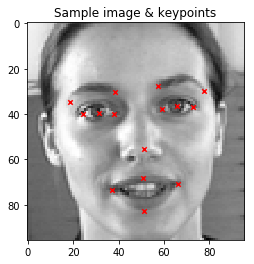

In [17]:
#Separate data into clean & unclean subsets
def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

clean_train_images = load_images(clean_train_data)
print("Shape of clean_train_images: {}".format(np.shape(clean_train_images)))
clean_train_keypoints = load_keypoints(clean_train_data)
print("Shape of clean_train_keypoints: {}".format(np.shape(clean_train_keypoints)))
test_images = load_images(test_data)
print("Shape of test_images: {}".format(np.shape(test_images)))

train_images = clean_train_images
train_keypoints = clean_train_keypoints
fig, axis = plt.subplots()
plot_sample(clean_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Sample image & keypoints")

if include_unclean_data:
    unclean_train_images = load_images(unclean_train_data)
    print("Shape of unclean_train_images: {}".format(np.shape(unclean_train_images)))
    unclean_train_keypoints = load_keypoints(unclean_train_data)
    print("Shape of unclean_train_keypoints: {}\n".format(np.shape(unclean_train_keypoints)))
    train_images = np.concatenate((train_images, unclean_train_images))
    train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

In [18]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints

if horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(clean_train_images, clean_train_keypoints)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
    print("Shape of flipped_train_keypoints: {}".format(np.shape(flipped_train_keypoints)))
    train_images = np.concatenate((train_images, flipped_train_images))
    train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped") 

Augmenting for angles (in degrees): 
12  -12  
Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)



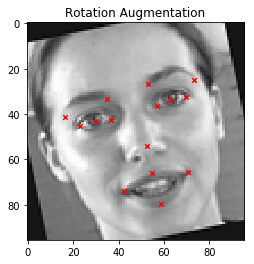

In [19]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)#transformation matrix
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

if rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(clean_train_images, clean_train_keypoints)
    print("\nShape of rotated_train_images: {}".format(np.shape(rotated_train_images)))
    print("Shape of rotated_train_keypoints: {}\n".format(np.shape(rotated_train_keypoints)))
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index], axis, "Rotation Augmentation")

Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)


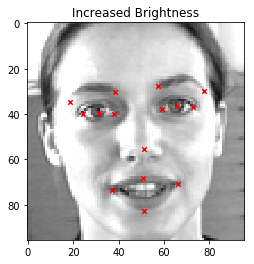

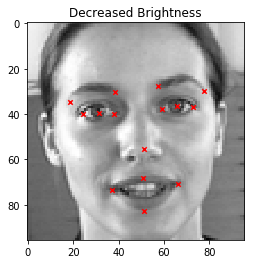

In [20]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(clean_train_images, clean_train_keypoints)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")
    print(f"Shape of altered_brightness_train_keypoints: {np.shape(altered_brightness_train_keypoints)}")
    train_images = np.concatenate((train_images, altered_brightness_train_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[sample_image_index], altered_brightness_train_keypoints[sample_image_index], axis, "Increased Brightness") 
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+sample_image_index], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+sample_image_index], axis, "Decreased Brightness") 

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)


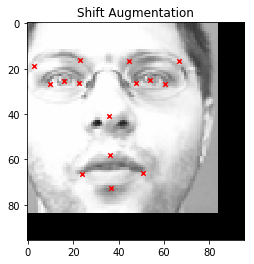

In [21]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(clean_train_images, clean_train_keypoints)
    print(f"Shape of shifted_train_images: {np.shape(shifted_train_images)}")
    print(f"Shape of shifted_train_keypoints: {np.shape(shifted_train_keypoints)}")
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[sample_image_index], shifted_train_keypoints[sample_image_index], axis, "Shift Augmentation")

Shape of noisy_train_images: (2140, 96, 96, 1)


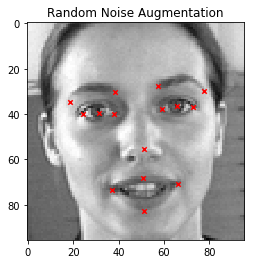

In [22]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if random_noise_augmentation:
    noisy_train_images = add_noise(clean_train_images)
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images)}")
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Random Noise Augmentation")

Shape of final train_images: (26239, 96, 96, 1)
Shape of final train_keypoints: (26239, 30)

 Clean Train Data: 


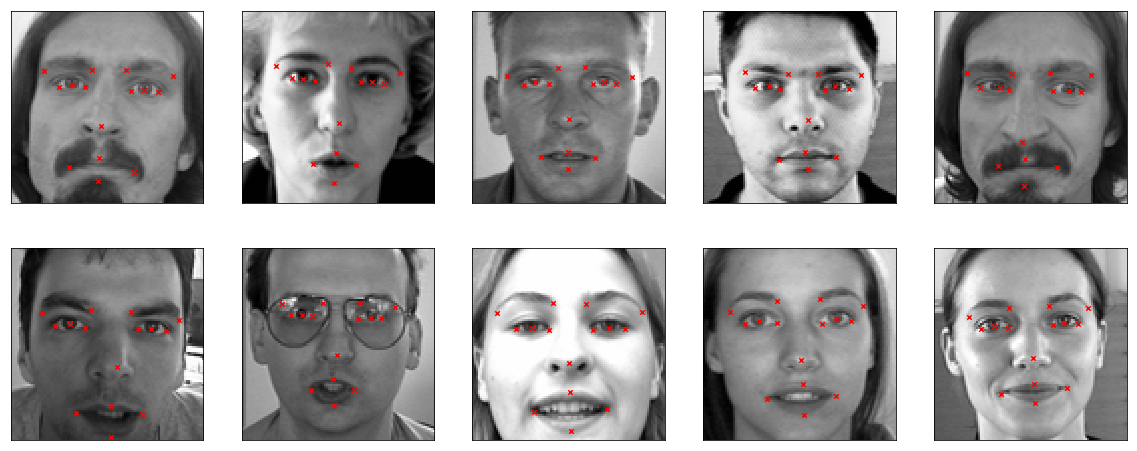

Unclean Train Data: 


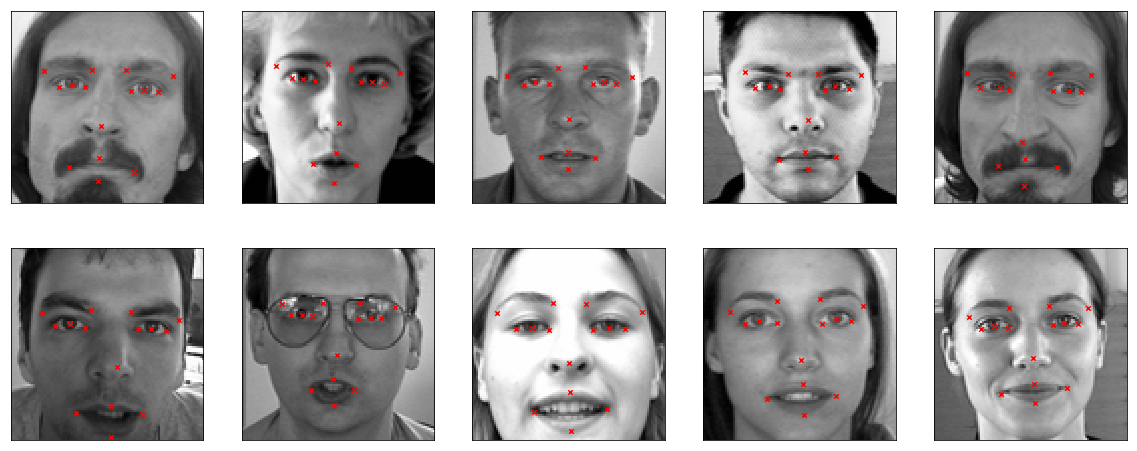

Rotation Augmentation: 


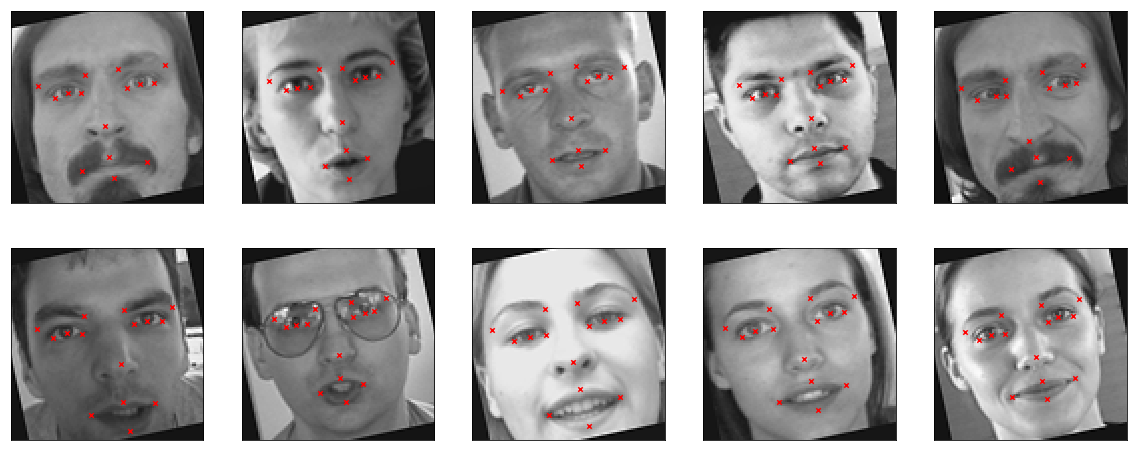

Brightness Augmentation: 


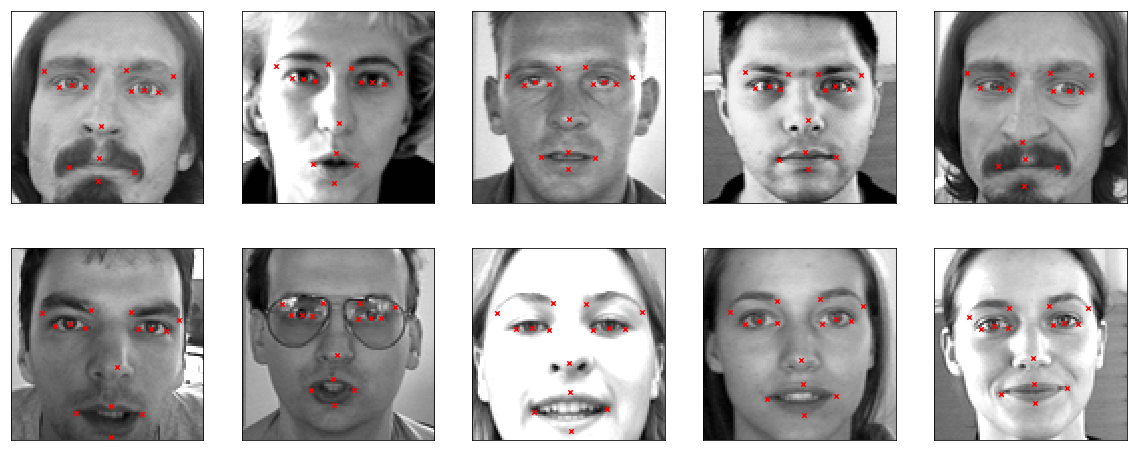

Shift Augmentation: 


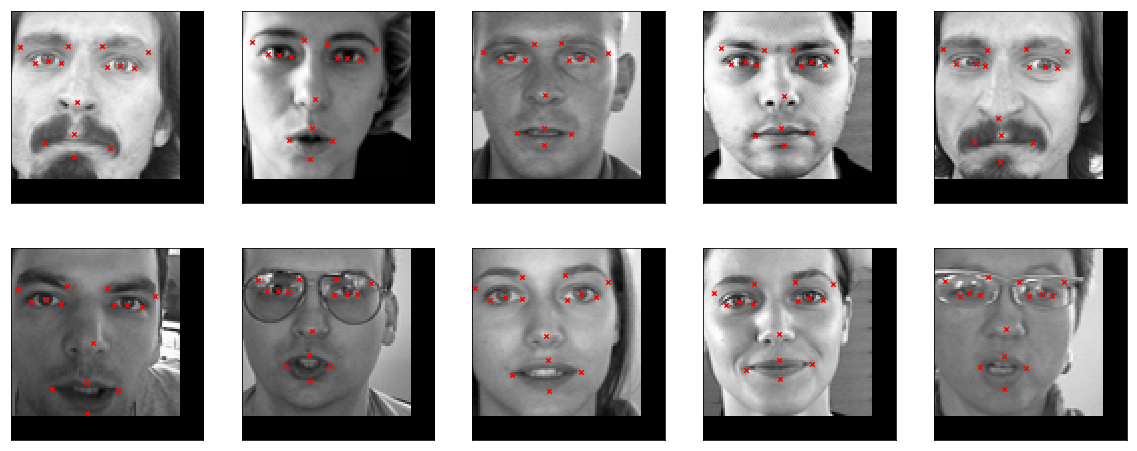

Random Noise Augmentation: 


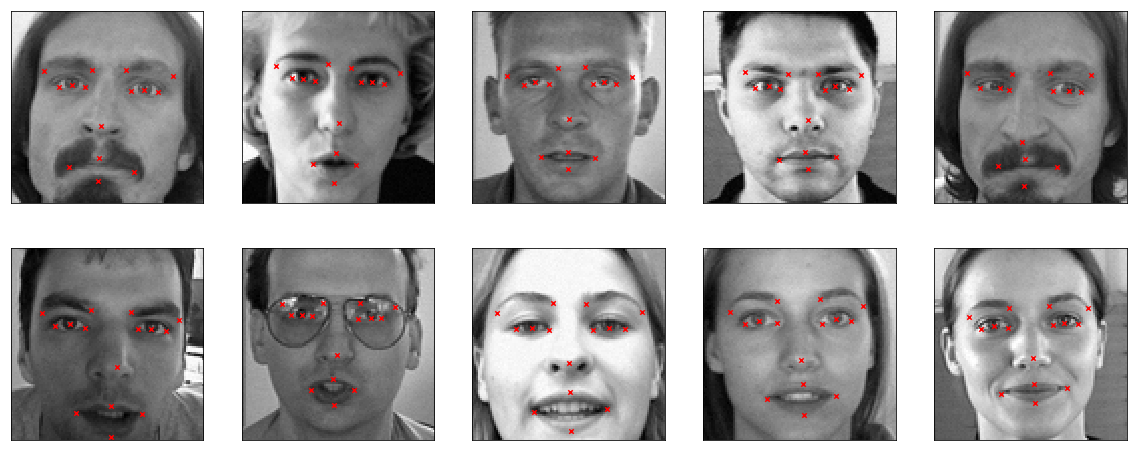

In [23]:
print("Shape of final train_images: {}".format(np.shape(train_images)))
print("Shape of final train_keypoints: {}".format(np.shape(train_keypoints)))

print("\n Clean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(clean_train_images[i], clean_train_keypoints[i], axis, "")
plt.show()

if include_unclean_data:
    print("Unclean Train Data: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(unclean_train_images[i], unclean_train_keypoints[i], axis, "")
    plt.show()

if horizontal_flip:
    print("Horizontal Flip Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

if rotation_augmentation:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()
    
if brightness_augmentation:
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

if shift_augmentation:
    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()
    
if random_noise_augmentation:
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], clean_train_keypoints[i], axis, "")
    plt.show()

In [24]:
train_keypoints.shape

(26239, 30)

In [25]:
np.save('train_images', train_images)
np.save('train_keypoints', train_keypoints)
np.save('test_images', test_images)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_images, train_keypoints, test_size=0.05, random_state=42)
x_train.shape, x_val.shape

In [ ]:
print(x_train[:,:,:,0].shape)
x_train=np.array([x_train[:,:,:,0],x_train[:,:,:,0],x_train[:,:,:,0]])
print(x_train.shape)

x_train=np.swapaxes(x_train,0,1)
x_train=np.swapaxes(x_train,1,2)
x_train=np.swapaxes(x_train,2,3)
x_train.shape

In [ ]:
print(x_val[:,:,:,0].shape)
x_val=np.array([x_val[:,:,:,0],x_val[:,:,:,0],x_val[:,:,:,0]])
print(x_val.shape)

x_val=np.swapaxes(x_val,0,1)
x_val=np.swapaxes(x_val,1,2)
x_val=np.swapaxes(x_val,2,3)
x_val.shape

In [ ]:
print(test_images[:,:,:,0].shape)
test=np.array([test_images[:,:,:,0],test_images[:,:,:,0],test_images[:,:,:,0]])
print(test.shape)


test=np.swapaxes(test,0,1)
test=np.swapaxes(test,1,2)
test=np.swapaxes(test,2,3)
test.shape

In [ ]:
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(include_top=False, input_shape=(96,96,3), pooling='avg')
base_model.trainable = False
base_model.summary()

In [ ]:
(2140, 30)
from keras.models import Sequential 
from keras.layers import Dense, Flatten,BatchNormalization, Dropout
from keras.optimizers import Adam
from keras import regularizers

top_model = Sequential([
    Dense(512, activation='relu', input_shape=(2048,),kernel_initializer='he_normal'), 
    Dense(256, activation='relu',kernel_initializer='he_normal'),
    Dropout(0.7),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal'),
    Dropout(0.7),
    Dense(96, activation='relu',kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal'),
    Dropout(0.7),
    Dense(48, activation='relu',kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal'),
    Dense(30)
])
top_model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mae'])
top_model.summary()

In [ ]:
final_model = Sequential([base_model, top_model])
final_model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mae'])
final_model.summary()

In [ ]:
precomputed_train = base_model.predict(x_train, batch_size=256, verbose=1)
precomputed_train.shape

In [ ]:
precomputed_val = base_model.predict(x_val, batch_size=256, verbose=1)
precomputed_val.shape

In [ ]:
log = top_model.fit(precomputed_train, y_train, epochs=600,
                    batch_size=256, validation_data=[precomputed_val, y_val])

In [ ]:
print(f'MAE final: {final_model.evaluate(x_val, y_val)[1]}')


In [ ]:
pred = final_model.predict(test)

In [ ]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(pred)
rowid = list(lookid_data['RowId'])


In [ ]:


feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))
    
    
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])


In [ ]:
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('face_key_detection_submission.csv',index = False)